In [1]:
from hcve_lib.splitting import train_test_fold
from hcve_lib.utils import notebook_init

notebook_init()

import pandas

from matplotlib import pyplot
from deps.logger import logger
from hcve_lib.tracking import get_completed_runs
from hcve_lib.tracking import is_root_run
from hcve_lib.tracking import get_children_runs
from deps.common import get_data_cached
from mlflow import get_experiment_by_name
from hcve_lib.utils import split_data
import numpy as np
from hcve_lib.tracking import load_pickled_artifact
from hcve_lib.visualisation import b
import mlflow

logger.setLevel('DEBUG')
pandas.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
pyplot.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data, metadata, X, y = get_data_cached()

In [3]:
def plot_splits(result):
    X_all_index = data.index
    mesh = get_mesh((len(result.keys()), len(X_all_index)))

    run_names = []
    for number, (name, fold) in enumerate(result.items()):
        X_train, y_train, X_test, y_test = split_data(*train_test_fold(data, fold, metadata), fold)
        row = X_all_index.to_numpy().copy()
        place_row_split_colors(mesh[number], row, X_train.index, X_test.index)
        run_names.append(name)


    pyplot.imshow(mesh, aspect='auto', interpolation='none')
    pyplot.xlabel('Individuals')
    pyplot.yticks(ticks=list(range(len(run_names))), labels=run_names)
    pyplot.ylabel('Iteration')
    pyplot.show()

def get_mesh(shape):
    return np.ones((*shape, 3), dtype='float')

def place_row_split_colors(mesh, all_index, train_index, test_index):
    mesh[np.isin(all_index, train_index)] = (0,1,0)
    mesh[np.isin(all_index, test_index)] = (1,0,0)

## Nested optimized LM

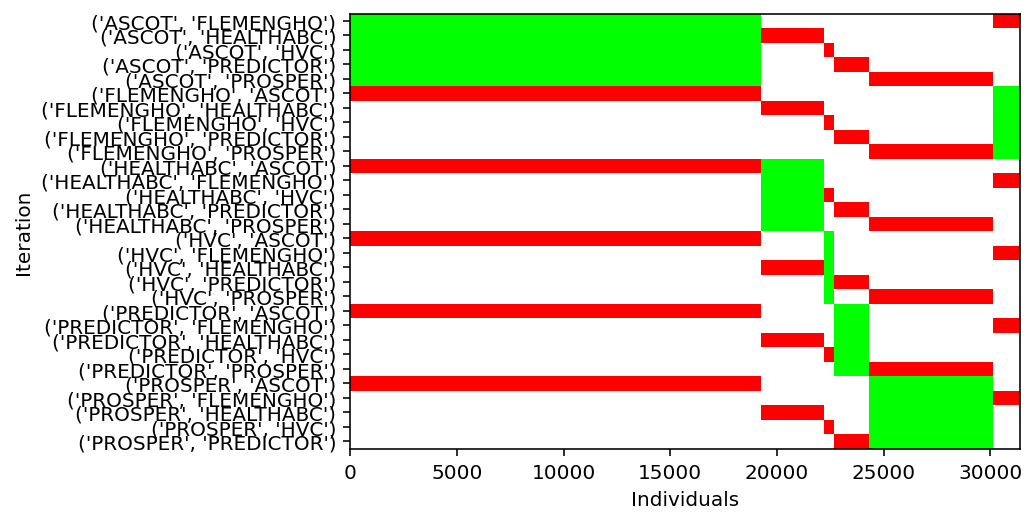

In [8]:
method_run_id = '0e80f95814c94f0a892a0c381c56b4e2'
result = load_pickled_artifact(method_run_id, 'result')
plot_splits(result)
# for nested_run in nested_runs:
#     b(nested_run['tags.mlflow.runName'])
#     result = load_pickled_artifact(nested_run['run_id'], 'result')
#     plot_splits(result)
# runs = mlflow.search_runs(
#     get_experiment_by_name('optimized_nested_lco').experiment_id,
#     f'tags.mlflow.parentRunId = "{root_run_id}"',
#     output_format='list')

# for nested_run in nested_runs:
#     b(nested_run['tags.mlflow.runName'])
#     result = load_pickled_artifact(nested_run['run_id'], 'result')
#     plot_splits(result)

In [ ]:
from hcve_lib.visualisation import p

for split_name, result_ in result.items():
    p(split_name)
    plot_splits(result_['model'].study.trials[0].user_attrs['result_split'])

## Optimized LCO

In [ ]:
runs = mlflow.search_runs(
        get_experiment_by_name('optimized_lco').experiment_id)
last_root_run = runs[is_root_run(runs)].iloc[0]
nested_runs = get_children_runs(runs, last_root_run.run_id).iloc

for nested_run in nested_runs:
    b(nested_run['tags.mlflow.runName'])
    result = load_pickled_artifact(nested_run['run_id'], 'result')
    plot_splits(result)


## Optimized 10 fold per study

In [ ]:
from hcve_lib.tracking import get_latest_root_run

runs = get_completed_runs('optimized_10_fold_per_study')
last_root_run = get_latest_root_run(runs)
nested_runs = get_children_runs(runs, last_root_run.run_id)

for _, nested_run in nested_runs.iterrows():
    b(nested_run['tags.mlflow.runName'])
    last_result = load_pickled_artifact(nested_run['run_id'], 'result')
    plot_splits(last_result)